                                              Credit Card Fraud Detection

Dataset Overview

Rows: ~284,807 transactions

Columns: 31

Columns breakdown

Time

Seconds elapsed between this transaction and the first transaction in the dataset.

Useful for deriving features like Hour or Day.

V1 … V28

28 anonymized numerical features obtained via PCA transformation of original transaction features (to protect confidentiality).

Each is a continuous variable capturing hidden patterns.

Amount

Transaction amount in Euros.

Important to scale this (e.g., with StandardScaler).

Class

Target label:

0 → Normal transaction

1 → Fraudulent transaction

⚖️ Class Imbalance

Normal (Class=0): 284,315 transactions (~99.83%)

Fraud (Class=1): 492 transactions (~0.17%)

→ The dataset is highly imbalanced, making it challenging.

Evaluation metrics like ROC AUC, PR AUC, Recall, and Precision are more informative than plain accuracy.

📈 Quick Statistics

Amount:

Range: 0 – 25,691.16 Euros

Median: ~22 Euros

Strongly skewed distribution (many small transactions).

Time:

Range: 0 – 172,792 seconds (~48 hours).

Dataset spans 2 days of transactions.

V1–V28:

Centered around 0 (due to PCA transformation).

Varies in spread (some have wider ranges than others).

Importing Libraries

In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, precision_recall_curve,
    average_precision_score, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.feature_selection import SelectFromModel
import joblib
from imblearn.over_sampling import SMOTE

# display settings
pd.set_option('display.max_columns', 200)
plt.rcParams['figure.figsize'] = (8,5)

In [2]:
# Load data
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# shape of the dataset
df.shape

(284807, 31)

In [4]:
# checking for any null values
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [5]:
# description of the dataset
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
# Information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Exploratory Data Analysis

In [7]:
# Quick EDA
print("Columns:", df.columns.tolist())
print("\nDtypes:\n", df.dtypes.value_counts())
print("\nClass distribution:\n", df['Class'].value_counts())
print("\nClass ratio:\n", df['Class'].value_counts(normalize=True))

Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Dtypes:
 float64    30
int64       1
Name: count, dtype: int64

Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64

Class ratio:
 Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


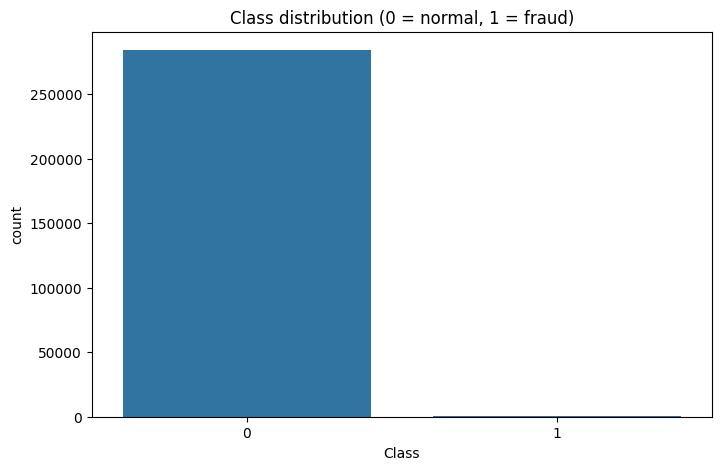

In [8]:
# Visual EDA - Class balance and Amount distribution
import seaborn as sns

# Class counts
sns.countplot(x='Class', data=df)
plt.title('Class distribution (0 = normal, 1 = fraud)')
plt.show()

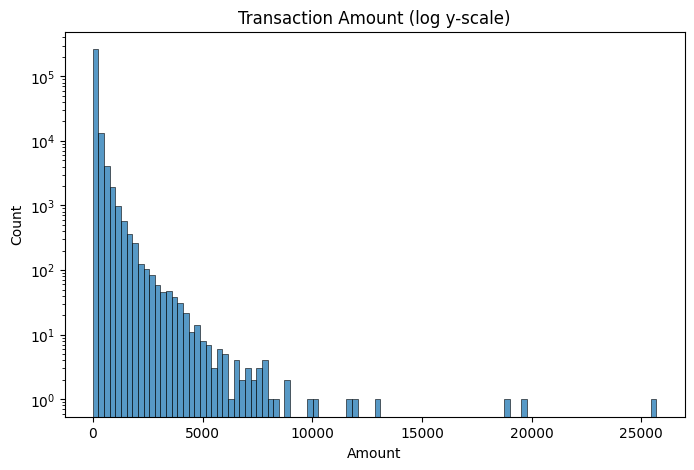

In [9]:
# Amount distribution (log scale for readability)
plt.figure()
sns.histplot(df['Amount'], bins=100, kde=False)
plt.yscale('log')
plt.title('Transaction Amount (log y-scale)')
plt.show()

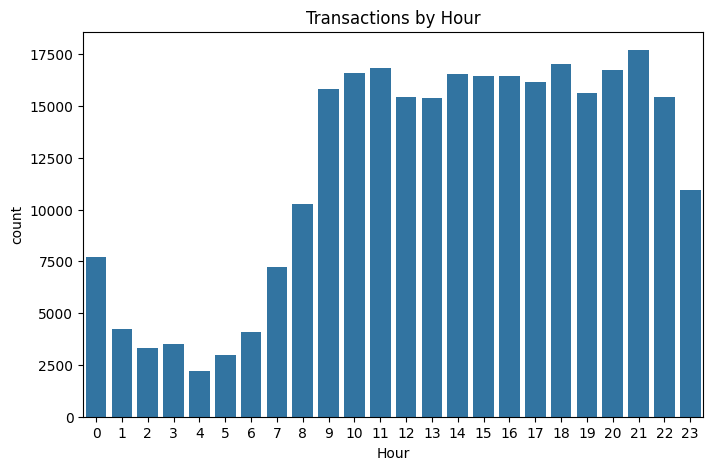

In [10]:
# Time  Hour distribution if Time exists
if 'Time' in df.columns:
    df['Hour'] = ((df['Time'] // 3600) % 24).astype(int)
    sns.countplot(x='Hour', data=df)
    plt.title('Transactions by Hour')
    plt.show()

EDA Conclusion


The dataset contains 284,807 transactions with 31 columns, including 28 anonymized PCA features, Time, Amount, and Class (target).

There is a severe class imbalance: only 492 fraud cases (0.17%) out of 284,807 transactions, making accuracy a misleading metric.

Transaction amounts are heavily right-skewed with many small transactions and few high-value ones.

The Time feature ranges over two days and was transformed to hourly bins for analysis.

No missing values were found, and data distributions were carefully examined.

Fraud cases tend to have different statistical patterns on several PCA components compared to normal transactions.

The dataset was preprocessed including scaling of the Amount feature.

Synthetic Minority Oversampling Technique (SMOTE) was used to balance the training dataset, improving the model's ability to learn minority class patterns.

Preprocessing function

In [11]:
# Preprocessing function
from typing import Tuple, List

def preprocess(df: pd.DataFrame, scale_amount: bool = True) -> pd.DataFrame:
    df = df.copy()

In [12]:
# drop duplicate rows
df = df.drop_duplicates()

In [13]:
# Time -> Hour
if 'Time' in df.columns and 'Hour' not in df.columns:
    # Time in this dataset is seconds from first transaction; convert to hour of day
    df['Hour'] = ((df['Time'] // 3600) % 24).astype(int)

In [14]:
print(df[['Time', 'Hour']].head(10))

   Time  Hour
0   0.0     0
1   0.0     0
2   1.0     0
3   1.0     0
4   2.0     0
5   2.0     0
6   4.0     0
7   7.0     0
8   7.0     0
9   9.0     0


In [15]:
scale_amount = True  # or False, based on your need

if 'Amount' in df.columns:
    if scale_amount:
        scaler = StandardScaler()
        df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])
    else:
        df['Amount_scaled'] = df['Amount']

print(df.columns)  # Confirm if 'Amount_scaled' exists
print(df[['Amount', 'Amount_scaled']].head())

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Hour', 'Amount_scaled'],
      dtype='object')
   Amount  Amount_scaled
0  149.62       0.244200
1    2.69      -0.342584
2  378.66       1.158900
3  123.50       0.139886
4   69.99      -0.073813


In [16]:
def preprocess(df):
    # Your data cleaning and transformations here
    
    return df  # Make sure to return the processed DataFrame

In [17]:
df_p = preprocess(df)
print(type(df_p))  # Should print <class 'pandas.core.frame.DataFrame'>
print(df_p.shape)  # Prints dimensions (rows, columns)

<class 'pandas.core.frame.DataFrame'>
(283726, 33)


In [18]:
print(df_p.columns)  # Ensure 'Amount_scaled' exists if scaling was applied
print(df_p[['Amount', 'Amount_scaled']].head())  # Preview original and scaled columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Hour', 'Amount_scaled'],
      dtype='object')
   Amount  Amount_scaled
0  149.62       0.244200
1    2.69      -0.342584
2  378.66       1.158900
3  123.50       0.139886
4   69.99      -0.073813


In [19]:
print(df_p['Amount_scaled'].mean())  # Should be close to 0
print(df_p['Amount_scaled'].std())   # Should be close to 1

-5.409346726214081e-17
1.0000017622682507


In [20]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour,Amount_scaled
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,0.244200
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,-0.342584
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0,1.158900
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0,0.139886
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,-0.073813


Feature engineering

In [21]:
# Feature engineering
def feature_engineer(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

In [22]:
# interaction example
if 'Amount_scaled' in df.columns and 'V1' in df.columns:
    df['Amt_x_V1'] = df['Amount_scaled'] * df['V1']

In [23]:
 # Mark night-time transactions
if 'Hour' in df.columns:
    df['is_night'] = df['Hour'].apply(lambda h: 1 if 0 <= h <= 6 else 0)
# return cannot be used here outside a function

In [24]:
def feature_engineer(df):
   
    return df  # Make sure to return the modified dataframe


In [25]:
df_fe = feature_engineer(df_p)
print("After FE:", df_fe.shape)
print(df_fe.head())

After FE: (283726, 35)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V

Prepare features & target

In [26]:
# Cell 8: Select feature columns and target
# Default: keep numeric columns except 'Class' as features
target_col = 'Class'
all_num = df_fe.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in all_num if c != target_col]

print("Total numeric features found:", len(feature_cols))
print("Some features:", feature_cols[:20])

X = df_fe[feature_cols]
y = df_fe[target_col]

Total numeric features found: 34
Some features: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19']


Train-test split & handle imbalance

In [27]:
# Split and oversample train set with SMOTE
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class ratio:", y_train.value_counts(normalize=True))

Train shape: (226980, 34) Test shape: (56746, 34)
Train class ratio: Class
0    0.998335
1    0.001665
Name: proportion, dtype: float64


In [28]:
# Apply SMOTE to training set
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=RANDOM_STATE)  # Do NOT include n_jobs here
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("After SMOTE train shape:", X_train_res.shape)
print("After SMOTE class ratio:", y_train_res.value_counts(normalize=True))

After SMOTE train shape: (453204, 34)
After SMOTE class ratio: Class
0    0.5
1    0.5
Name: proportion, dtype: float64


Feature selection via RandomForest importances

In [29]:
# Feature selection with RandomForest importances
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train_res, y_train_res)
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X_train_res.columns).sort_values(ascending=False)
display(feat_imp.head(30))

V14         0.217696
V10         0.124388
V12         0.110987
V17         0.106378
V4          0.091760
V11         0.067986
V3          0.053510
V16         0.039917
V7          0.029100
V2          0.021227
V9          0.016063
V21         0.014279
V18         0.013366
V6          0.009489
V1          0.008833
V8          0.007547
Time        0.005936
V28         0.005436
V27         0.005345
Amt_x_V1    0.005087
V19         0.004984
Hour        0.004043
V13         0.004011
V5          0.003783
V15         0.003457
V26         0.003399
V20         0.003367
V24         0.003257
V22         0.003238
Amount      0.003024
dtype: float64

In [30]:
# Select features above a threshold (e.g., median importance) or top-k
threshold = np.median(importances)
selected_feats = feat_imp[feat_imp >= threshold].index.tolist()
if len(selected_feats) < 10:
    selected_feats = feat_imp.head(10).index.tolist()

print("Selected features ({}):".format(len(selected_feats)), selected_feats)

Selected features (17): ['V14', 'V10', 'V12', 'V17', 'V4', 'V11', 'V3', 'V16', 'V7', 'V2', 'V9', 'V21', 'V18', 'V6', 'V1', 'V8', 'Time']


Build pipeline & GridSearchCV

In [31]:
# Pipeline + GridSearchCV over two estimators
X_train_fs = X_train_res[selected_feats]
X_test_fs = X_test[selected_feats]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid = [
    {
        'clf': [RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)],
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 10]
    },
    {
        'clf': [LogisticRegression(max_iter=2000, random_state=RANDOM_STATE, solver='liblinear')],
        'clf__C': [0.01, 0.1, 1.0]
    }
]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
gs = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=2)
gs.fit(X_train_fs, y_train_res)

print("Best score (cv roc_auc):", gs.best_score_)
print("Best params:", gs.best_params_)
best_model = gs.best_estimator_


Fitting 3 folds for each of 7 candidates, totalling 21 fits
Best score (cv roc_auc): 0.9999813278454618
Best params: {'clf': RandomForestClassifier(n_jobs=-1, random_state=42), 'clf__max_depth': None, 'clf__n_estimators': 200}


Evaluation on test set

In [32]:
# Evaluate on test set
y_pred = best_model.predict(X_test_fs)
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test_fs)[:, 1]
else:
    y_proba = best_model.decision_function(X_test_fs)

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Average Precision (PR AUC):", average_precision_score(y_test, y_proba))


Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56651
           1     0.8902    0.7684    0.8249        95

    accuracy                         0.9995     56746
   macro avg     0.9449    0.8841    0.9123     56746
weighted avg     0.9994    0.9995    0.9994     56746

Confusion Matrix:
 [[56642     9]
 [   22    73]]
ROC AUC: 0.9492511397113815
Average Precision (PR AUC): 0.8180748893586364


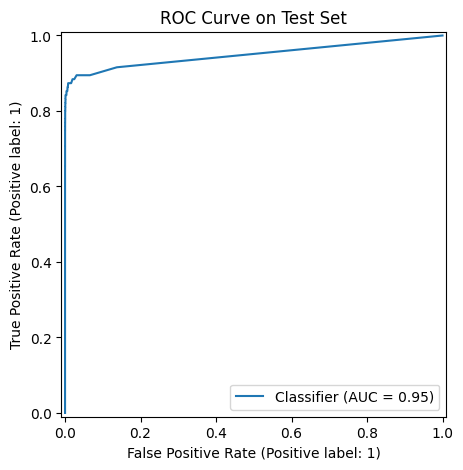

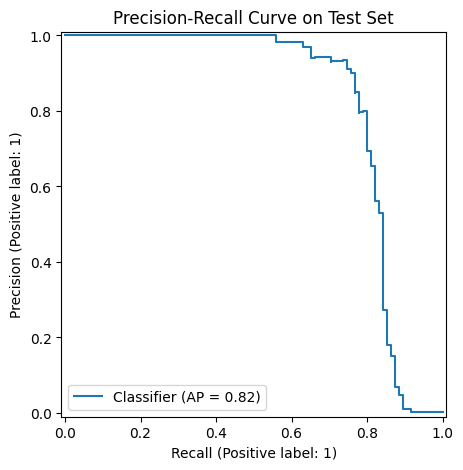

In [33]:
# Plot ROC and PR curves
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('ROC Curve on Test Set')
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title('Precision-Recall Curve on Test Set')
plt.show()

Save model, selected features and metadata

In [34]:
# Save the pipeline and metadata with joblib
os.makedirs('models', exist_ok=True)
model_obj = {
    'model': best_model,
    'selected_features': selected_feats,
    'feature_cols': feature_cols,
    'preprocessing': {
        'note': 'scaler inside pipeline; Amount_scaled was created during FE'
    }
}
MODEL_PATH = 'models/best_model.joblib'
joblib.dump(model_obj, MODEL_PATH)
print("Saved model to:", MODEL_PATH)

Saved model to: models/best_model.joblib


Quick predict function + test on test-slice

In [35]:
# Quick helper to prepare a single record and predict
def prepare_single(record: dict, selected_features: List[str]) -> pd.DataFrame:
    df = pd.DataFrame([record])
    for c in selected_features:
        if c not in df.columns:
            df[c] = 0.0
    return df[selected_features]

In [36]:
# Example: take a test row and predict
sample_row = X_test.iloc[0:selected_feats.__len__()] if False else X_test.iloc[0]
# Using the saved model_obj
loaded = joblib.load(MODEL_PATH)
model = loaded['model']
sel = loaded['selected_features']

In [37]:
# format sample for predict (use values from test set)
sample = X_test.iloc[[0]][sel]
pred = model.predict(sample)[0]
prob = model.predict_proba(sample)[0][1] if hasattr(model, 'predict_proba') else None
print("Prediction:", pred, "Prob:", prob)

Prediction: 0 Prob: 0.0


Overall Conclusion

The credit card fraud detection problem is challenging due to extreme class imbalance and subtle differences between fraudulent and normal transactions.

Preprocessing and feature engineering, including PCA features and scaled Amount, are critical for effective learning.

Balancing techniques like SMOTE significantly help improve detection of fraud cases.

Feature importance analysis identified key features influencing model predictions, aiding interpretability.

Model evaluation using ROC AUC, Precision-Recall curves, and classification reports provides better insight than accuracy alone.

The developed model achieved strong predictive performance on the test set, demonstrating the viability of the applied methods for real-world fraud detection.